# Ensemble Learning and Random Forests

* If you aggregate the predictions of a group of predictors (such as classifiers or regressors), you will often get better predictions than with the best individual predictor.

* A group of predictors is called an ensemble; thus, this technique is called ensemble learning, and an ensemble learning algorithm is called an ensemble method.
    * Example: You can train a group of decision tree classifiers, each on a different random subset of the training set. You can then obtain the predictions of all the individual trees, and the class that gets the most votes is the ensemble’s prediction. Such an ensemble of decision trees is called a random forest, and despite its simplicity, this is one of the most powerful machine learning algorithms available today.


# A. Voting Classifiers:
* Suppose you have trained a few classifiers, each one achieving about 80% accuracy. You may have a logistic regression classifier, an SVM classifier, a random forest classifier, a k-nearest neighbors classifier, and perhaps a few more: <br><br>
    &emsp; &emsp; ![Alt text](image-10.png)
    <br><br>
    
* **Hard Voting** classifier:
    * Majority-vote classifier , after aggregating the predictions of each classifier, the class that gets the most votes is the ensembles prediction.
    <br><br>
    &emsp; &emsp; ![Alt text](image-11.png)

* Even if each classifier is a weak learner (meaning it does only slightly better than random guessing), the ensemble can still be a strong learner (achieving high accuracy), provided there are a sufficient number of weak learners in the ensemble and they are sufficiently diverse. 
    * Law of Large Numbers:  The law of large numbers states that the the average of results from a large number of experiment trials:   
        * should be close to the expected value 
        * will move closer to the expected value as more trials are performed

    * Suppose you build an ensemble containing 1,000 classifiers that are individually correct only 51% of the time (barely better than random guessing.). If you predict the majority voted class, you can hope for up to 75% accuracy. However, this is only true if all classifiers are perfectly independent, making uncorrelated errors, which is clearly not the case because they are trained on the same data. They are likely to make the same types of errors, so there will be many majority votes for the wrong class, reducing the ensemble’s accuracy.

    * Ensemble methods work best when the predictors are as independent from one another as possible. One way to get diverse classifiers is to train them using very different algorithms. This increases the chance that they will make very different types of errors, improving the ensemble’s accuracy.

* `VotingClassifier`
    * A class in scikit-learn for creating voting classifiers.
    * When you fit a `VotingClassifier`, it clones every estimator and fits the clones. The original estimators are available via the `estimators` attribute, while the fitted clones are available via the `estimators_` attribute.
    * Calling the voting classifier's `predict()` will perform hard voting.

* **Soft Voting**:
    * If all classifiers are able to estimate class probabilities (i.e., if they all have a `predict_proba()` method), then scikit-learn can be set to predict the class w/ the highest class probability, averaged over all the individual classifiers. This is called Soft Voting.
        * This can be done by setting the voting classifier's `voting` hyperparameter to `"soft"`, and ensure that all classifiers can estimate probabilities.
        * For `SVC` class, you need to set its `probability` hyperparameter to `True`, but this will make `SVC` class to use cross-validation to estimate class probabilities, slowing down training , but will add a `predict_proba()` method.
    * Soft voting often achieves higher performance than hard voting because it gives more weight to highly confident votes.



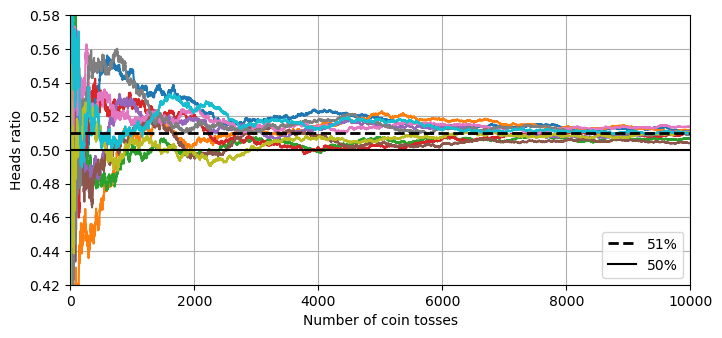

In [1]:
import matplotlib.pyplot as plt
import numpy as np

heads_proba = 0.51
np.random.seed(42)
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads = coin_tosses.cumsum(axis=0)
cumulative_heads_ratio = cumulative_heads / np.arange(1, 10001).reshape(-1, 1)

plt.figure(figsize=(8, 3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
plt.grid();

In [2]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [4]:
X, y = make_moons(n_samples=500, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(random_state=42))
        ]
    )

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [5]:
for name, clf in voting_clf.named_estimators_.items():
    print(name, "=", clf.score(X_test, y_test))

lr = 0.864
rf = 0.896
svc = 0.896


In [6]:
voting_clf.predict(X_test[:1])

array([1], dtype=int64)

In [7]:
[clf.predict(X_test[:1]) for clf in voting_clf.estimators_]

[array([1], dtype=int64), array([1], dtype=int64), array([0], dtype=int64)]

In [8]:
voting_clf.score(X_test, y_test)

0.912

In [9]:
# Setting the voting classifier as Soft Voting classifier
voting_clf.voting = "soft"
voting_clf.named_estimators["svc"].probability = True
voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)

0.92

# B. Bagging and Pasting:

* Another approach in getting a diverse set of classifiers , aside from using very different training algorithms, is the use the same training algorithm for every predictor but train them on different random subsets of the training set.
    * Bagging (Bootstrap Sampling):
        * Sampling is performed w/ replacement.
    * Pasting:
        * Sampling is performed w/o replacement.

    * Both Bagging and pasting allows training instances to be sampled several times across multiple predictors, but only bagging allows training instances to be sampled several times for the same predictor. <br>
    &emsp; ![Alt text](image-12.png) <br>

    * Once all predictors are trained, the ensemble can make a prediction for a new instance by simply aggregating the predictions of all predictors. The aggregation function is typically the statistical mode for classification (most frequent prediction) or the average for regression.
    * Each individual predictor has a higher bias than if it were trained on the original training set, but aggregation reduces both bias and variance.
    * Generally, the net result is that the ensemble has a similar bias but a lower variance than a single predictor trained on the original training set.

    * Predictors can all be trained in parallel, via different CPU cores or even different servers. Similarly, predictions can be made in parallel. Bagging and Pasting scale very well.

### B.1 Bagging and Pasting in Scikit-Learn:

* `BaggingClassifier` for Classification, `BagginRegressor` for Regression.
    * `BaggingClassifier` automatically performs soft voting instead of hard voting if the base classifier can estimate class probabilities.
    * Bagging introduces a bit more diversity in the subsets that each predictor is trained on, so bagging ends up w/ a slightly higher bias than pasting, so the ensemble's variance is reduced. Overall, bagging often results in better models.
        * CV can be used to evaluate both bagging vs. pasting, and select the one that works best.

In [11]:
# Bagging, default `bootstrap=False`

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), 
    n_estimators=500, # 500 decision trees
    max_samples=100, # 100 training instances randomly sampled per decision tree
    n_jobs=-1,
    random_state=42
)

bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, random_state=42)

''

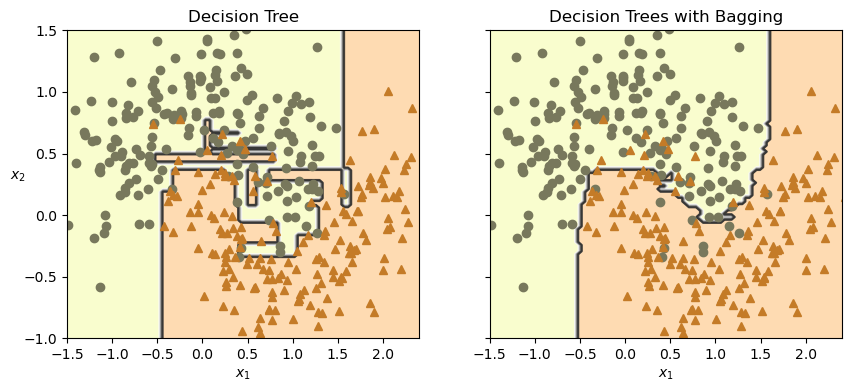

In [12]:
def plot_decision_boundary(clf, X, y, alpha=1.0):
    axes=[-1.5, 2.4, -1, 1.5]
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    plt.contourf(x1, x2, y_pred, alpha=0.3 * alpha, cmap='Wistia')
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8 * alpha)
    colors = ["#78785c", "#c47b27"]
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[idx], marker=markers[idx], linestyle="none")
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X_train, y_train)
plt.title("Decision Tree")
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X_train, y_train)
plt.title("Decision Trees with Bagging")
plt.ylabel("")
;